In [1]:
import tensorflow as tf
print("TensorFlow Version:", tf.__version__)
print("Is GPU available?:", tf.test.is_gpu_available()) # Deprecated in TF2.x, but works for quick check
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


TensorFlow Version: 2.18.0
Is GPU available?: True
Num GPUs Available: 1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import re # For simple text cleaning
import random # For shuffling our custom word lists
from sklearn.manifold import TSNE # For visualizing higher-dimensional embeddings

# Define categories and their words
dog_cat_words = ['dog', 'cat', 'pet', 'house', 'animal', 'sleep', 'play']
family_words = ['girl', 'boy', 'father', 'mother', 'family', 'house', 'marriage']
king_queen_words = ['crown', 'queen', 'king', 'empire', 'country', 'rule', 'castle']

# Generate a larger corpus by shuffling and appending words
num_repetitions = 10000 # Repeat each group's shuffled words 10,000 times

corpus_segments = []
for _ in range(num_repetitions):
    random.shuffle(dog_cat_words)
    corpus_segments.append(' '.join(dog_cat_words))

for _ in range(num_repetitions):
    random.shuffle(family_words)
    corpus_segments.append(' '.join(family_words))

for _ in range(num_repetitions):
    random.shuffle(king_queen_words)
    corpus_segments.append(' '.join(king_queen_words))

# Combine into a single large corpus string and then split for tokenization
corpus_string = ' '.join(corpus_segments)
# A more robust split into "sentences" (even if just segments)
corpus_list = re.split(r'[.!?]', corpus_string)

print(f"Generated a corpus with approximately {len(corpus_string.split())} words.")
print("Sample of the generated corpus (first 200 characters):\n", corpus_string[:200], "...")

Generated a corpus with approximately 210000 words.
Sample of the generated corpus (first 200 characters):
 sleep dog house play animal cat pet cat pet dog play house sleep animal animal pet cat house play sleep dog animal cat pet dog play house sleep dog sleep cat animal play house pet play house dog cat p ...


In [3]:
# 1. Tokenization & Lowercasing
def tokenize(text):
    text = text.lower()
    tokens = re.findall(r'\b\w+\b', text)
    return tokens

tokenized_corpus = [tokenize(sentence) for sentence in corpus_list if sentence.strip()] # filter empty strings
flat_tokenized_corpus = [word for sublist in tokenized_corpus for word in sublist]

# 2. Vocabulary Creation & 3. Word-to-Index Mappings
word_to_idx = defaultdict(lambda: len(word_to_idx))
idx_to_word = {}

for word in flat_tokenized_corpus:
    if word not in word_to_idx:
        idx = word_to_idx[word]
        idx_to_word[idx] = word

vocab_size = len(word_to_idx)

print("\nVocabulary Size:", vocab_size)
print("Sample word_to_idx:", dict(list(word_to_idx.items())[:5])) # Show first 5
print("Sample idx_to_word:", dict(list(idx_to_word.items())[:5])) # Show first 5


Vocabulary Size: 20
Sample word_to_idx: {'sleep': 0, 'dog': 1, 'house': 2, 'play': 3, 'animal': 4}
Sample idx_to_word: {0: 'sleep', 1: 'dog', 2: 'house', 3: 'play', 4: 'animal'}


In [5]:
# Function to generate context-target pairs
def generate_cbow_pairs(tokenized_sentences, word_to_idx, window_size=2):
    data = []
    for sentence in tokenized_sentences:
        sentence_indices = [word_to_idx[word] for word in sentence]
        for i, target_idx in enumerate(sentence_indices):
            context_indices = []
            # Get words before the target
            for j in range(max(0, i - window_size), i):
                context_indices.append(sentence_indices[j])
            # Get words after the target
            for j in range(i + 1, min(len(sentence_indices), i + window_size + 1)):
                context_indices.append(sentence_indices[j])

            # For TensorFlow, we need a consistent shape for context.
            # Pad with a dummy index (e.g., -1 or vocab_size for padding_idx) if context is smaller than expected
            # For simplicity, we'll only include pairs with full context window for now or pad later
            # It's better to pad context_indices to a fixed size (2 * window_size) if they are not always full.
            # However, for CBOW where we average embeddings, a variable length context is fine for a custom loop,
            # but for tf.keras.Model input, we typically need padded sequences.
            # Let's adjust to pass the list of context indices, and average in the model.

            if context_indices: # Ensure there are context words
                data.append((context_indices, target_idx))
    return data

window_size = 2
cbow_pairs = generate_cbow_pairs(tokenized_corpus, word_to_idx, window_size)

print(f"\nGenerated {len(cbow_pairs)} CBOW pairs.")
print("Sample CBOW Pairs (Context Indices, Target Index):")
for i in range(min(5, len(cbow_pairs))): # Print first 5 pairs
    context_words = [idx_to_word[idx] for idx in cbow_pairs[i][0]]
    target_word = idx_to_word[cbow_pairs[i][1]]
    print(f"  Context: {context_words} -> Target: {target_word}")

# Convert to TensorFlow Dataset for efficient processing
# Contexts will be lists of varying lengths, targets are single integers
# For tf.data.Dataset, we need a consistent shape. Let's make context a fixed length list of indices
# And if a context doesn't fill the window, we pad it with a special UNK/PAD token index.
# For simplicity, let's find the max context length and pad.
max_context_len = (2 * window_size)
padded_cbow_pairs = []
for context_indices, target_idx in cbow_pairs:
    padded_context = context_indices + [word_to_idx['<PAD>']] * (max_context_len - len(context_indices))
    # Note: Need to add '<PAD>' to vocabulary first if it's not naturally present.
    # For now, let's assume we filter to only full contexts or handle variable length input within the model.
    # A simpler approach for the model to handle variable length context: pass each word index separately.

# For a tf.keras.Model, it's easier to pass all context word indices as separate inputs,
# look up their embeddings, and then average them. This means the input layer
# receives a list of indices, not an aggregated one-hot.

# Let's prepare data as (list of context word IDs, target word ID)
X_train = [pair[0] for pair in cbow_pairs]
Y_train = [pair[1] for pair in cbow_pairs]

# We need to ensure X_train has a consistent shape for tf.data.Dataset.
# The most straightforward way for CBOW with Keras is to pad the context sequences.
# Let's add a padding token to our vocabulary
if '<PAD>' not in word_to_idx:
    pad_idx = vocab_size # Assign index after all existing words
    word_to_idx['<PAD>'] = pad_idx
    idx_to_word[pad_idx] = '<PAD>'
    vocab_size += 1 # Update vocab_size

# Re-generate CBOW pairs with padding logic
cbow_pairs_padded = []
for sentence in tokenized_corpus:
    sentence_indices = [word_to_idx[word] for word in sentence]
    for i, target_idx in enumerate(sentence_indices):
        context_indices = []
        for j in range(max(0, i - window_size), i):
            context_indices.append(sentence_indices[j])
        for j in range(i + 1, min(len(sentence_indices), i + window_size + 1)):
            context_indices.append(sentence_indices[j])

        # Pad contexts to max_context_len
        padded_context = context_indices + [word_to_idx['<PAD>']] * (2 * window_size - len(context_indices))
        if len(padded_context) > 0: # Only add if context is valid (not just target at start/end of sentence, if window allows)
             cbow_pairs_padded.append((padded_context, target_idx))


X_train_padded = np.array([pair[0] for pair in cbow_pairs_padded])
Y_train_padded = np.array([pair[1] for pair in cbow_pairs_padded])

print(f"\nGenerated {len(cbow_pairs_padded)} PADDED CBOW pairs.")
print(f"Shape of X_train_padded: {X_train_padded.shape}")
print(f"Shape of Y_train_padded: {Y_train_padded.shape}")

# Create TensorFlow Dataset
BUFFER_SIZE = tf.data.AUTOTUNE
# Create TensorFlow Dataset
# BUFFER_SIZE = tf.data.AUTOTUNE  # Original line
BATCH_SIZE = 1024 # Larger batch size for GPU efficiency

# Use a concrete buffer size for shuffle, ideally at least the size of the dataset
# We can use the number of padded pairs generated
SHUFFLE_BUFFER_SIZE = len(cbow_pairs_padded)
# If the dataset is very large, a smaller, fixed buffer size can be used,
# but a larger buffer improves the randomness of the shuffle.

dataset = tf.data.Dataset.from_tensor_slices((X_train_padded, Y_train_padded))
# Use the concrete buffer size for shuffle
dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("\nTensorFlow Dataset created successfully.")


Generated 210000 CBOW pairs.
Sample CBOW Pairs (Context Indices, Target Index):
  Context: ['dog', 'house'] -> Target: sleep
  Context: ['sleep', 'house', 'play'] -> Target: dog
  Context: ['sleep', 'dog', 'play', 'animal'] -> Target: house
  Context: ['dog', 'house', 'animal', 'cat'] -> Target: play
  Context: ['house', 'play', 'cat', 'pet'] -> Target: animal

Generated 210000 PADDED CBOW pairs.
Shape of X_train_padded: (210000, 4)
Shape of Y_train_padded: (210000,)

TensorFlow Dataset created successfully.


In [12]:
# Hyperparameters
embedding_dim = 2 # Still using 2D for direct plotting
# vocab_size is already determined in data prep

# Define the CBOW model using Keras Functional API or Subclassing
class CBOWModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOWModel, self).__init__()
        # Embedding layer: this is where our word vectors (W_in) will be learned.
        # input_dim is vocab_size, output_dim is embedding_dim
        # input_length is the number of context words (2 * window_size)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=2*window_size)
        # Dense output layer: maps the averaged embedding to vocabulary size for prediction
        self.dense = tf.keras.layers.Dense(vocab_size, activation='softmax')

    def call(self, inputs):
        # inputs will be a batch of context word indices: (batch_size, 2 * window_size)

        # Lookup embeddings for each context word
        embeddings = self.embedding(inputs) # Shape: (batch_size, 2 * window_size, embedding_dim)

        # Average the context word embeddings (the "Bag-of-Words" part)
        # axis=1 averages across the context words for each example in the batch
        mean_embedding = tf.reduce_mean(embeddings, axis=1) # Shape: (batch_size, embedding_dim)

        # Pass the averaged embedding to the output layer for prediction
        predictions = self.dense(mean_embedding) # Shape: (batch_size, vocab_size)
        return predictions

# Instantiate the model
model = CBOWModel(vocab_size, embedding_dim)

# Compile the model
# Optimizer: Adam is a good general-purpose choice
# Loss: SparseCategoricalCrossentropy is suitable for integer targets and softmax output
# Metrics: 'accuracy' to see prediction performance (though not our main goal here)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Build the model to see summary (pass dummy input to infer shapes)
dummy_input = tf.zeros((1, 2 * window_size), dtype=tf.int32)
model.build(dummy_input.shape)

print("\nCBOW Model Architecture:")
model.summary()


CBOW Model Architecture:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'cbow_model_6', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "cbow_model_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Starting training...
Epoch 1/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1221 - loss: 2.9003
Epoch 2/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1363 - loss: 2.3161
Epoch 3/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1432 - loss: 2.0576
Epoch 4/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1672 - loss: 1.9808
Epoch 5/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1853 - loss: 1.9473
Epoch 6/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1987 - loss: 1.9268
Epoch 7/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2102 - loss: 1.9144
Epoch 8/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2048 - loss: 1.9067
Epoch 9/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2160 - loss: 1.9007
Epoch 10/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2239 - loss: 1.8956
Epoch 11/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2243 - loss: 1.8924
Epoch 12/20
206/206 ━━━━━━━━━━

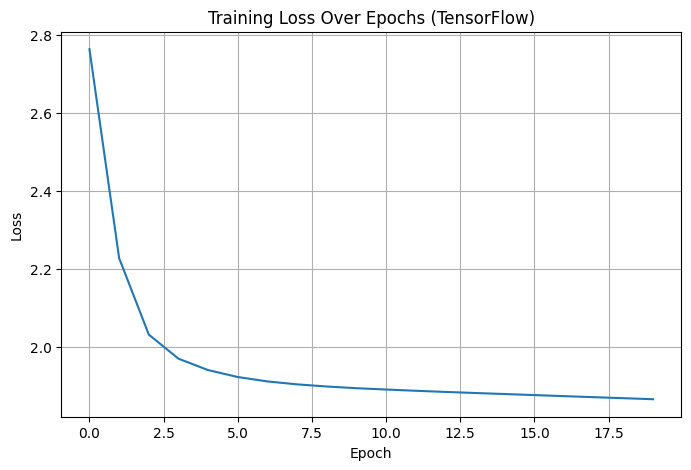

Figure 15: Training Loss Plot.


In [14]:
print("\nStarting training...")
history = model.fit(dataset, epochs=20)

# Visualization of Training Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'])
plt.title("Training Loss Over Epochs (TensorFlow)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()
print("Figure 15: Training Loss Plot.")

In [15]:
model.summary()

Model: "cbow_model_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 4, 2)           │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 20)             │            60 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 302 (1.18 KB)

 Trainable params: 100 (400.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 202 (812.00 B)


Sample Learned Embeddings (first 5 words):
  sleep: [ 4.829169  -1.6059505]
  dog: [ 5.036294  -1.6464283]
  house: [-1.346047   2.7558987]
  play: [ 5.7857375 -1.2714692]
  animal: [ 7.7177463 -0.8314443]


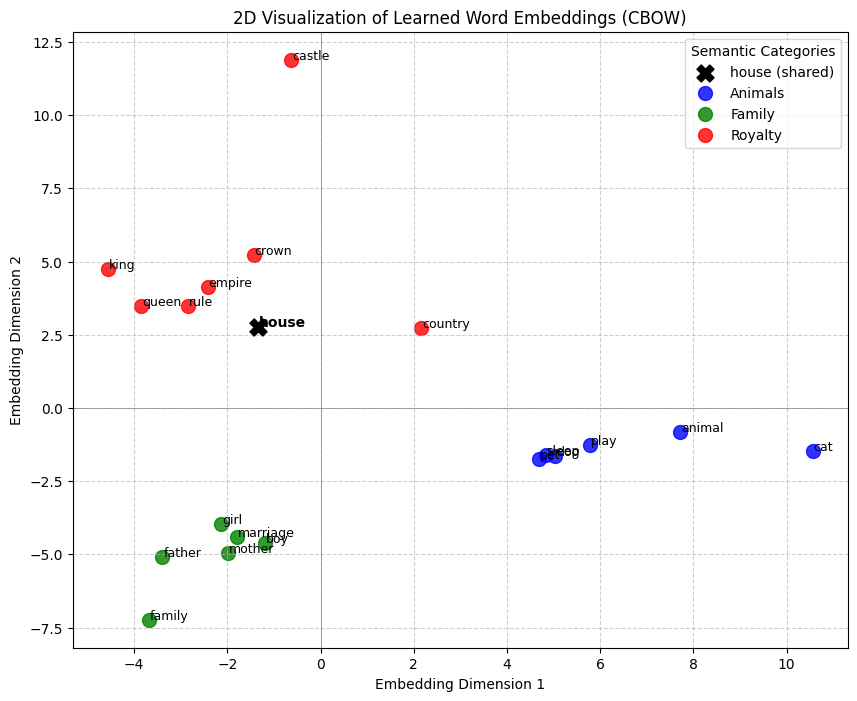


Figure 16: 2D Visualization of Learned Word Embeddings.

Cosine Similarities:
  One or both words ('fox', 'dog') not in vocabulary.
  Similarity('cat', 'animal'): 0.9995
  Similarity('king', 'queen'): 0.9976
  Similarity('father', 'mother'): 0.9787
  Similarity('dog', 'king'): -0.8820
  Similarity('cat', 'girl'): -0.3471
  Similarity('house', 'family'): -0.6021
  Similarity('house', 'animal'): -0.5326
  Similarity('play', 'sleep'): 0.9945

Figure 17: Cosine Similarity Check.


In [17]:
# The learned embeddings are the weights of the embedding layer
learned_embeddings = model.get_layer('embedding_6').get_weights()[0] # [0] because get_weights() returns a list

print("\nSample Learned Embeddings (first 5 words):")
for i in range(min(5, vocab_size)):
    word = idx_to_word[i]
    if word != '<PAD>': # Don't print padding embedding
        embedding = learned_embeddings[i]
        print(f"  {word}: {embedding}")

# Group words by their original category for colored plotting
# Filter out 'house' as it's shared and will be plotted separately
category_words = {
    "Animals": [w for w in ['dog', 'cat', 'pet', 'animal', 'sleep', 'play'] if w != 'house'],
    "Family": [w for w in ['girl', 'boy', 'father', 'mother', 'family', 'marriage'] if w != 'house'],
    "Royalty": ['crown', 'queen', 'king', 'empire', 'country', 'rule', 'castle']
}
category_colors = {
    "Animals": "blue",
    "Family": "green",
    "Royalty": "red"
}

# 2D Visualization of Learned Embeddings
plt.figure(figsize=(10, 8))

# Plot 'house' separately if it's in vocabulary and not part of the main categories loop
house_idx = word_to_idx.get('house')
if house_idx is not None and house_idx < vocab_size -1 : # Ensure it's not the padding index
    house_embedding = learned_embeddings[house_idx]
    plt.scatter(house_embedding[0], house_embedding[1], color='black', s=150, marker='X', label='house (shared)', zorder=5)
    plt.annotate('house', (house_embedding[0] + 0.03, house_embedding[1] + 0.03), fontsize=10, color='black', weight='bold')

for category_name, words in category_words.items():
    x_coords = []
    y_coords = []
    labels = []
    for word in words:
        if word in word_to_idx:
            idx = word_to_idx[word]
            vec = learned_embeddings[idx]
            x_coords.append(vec[0])
            y_coords.append(vec[1])
            labels.append(word)

    plt.scatter(x_coords, y_coords, color=category_colors[category_name], s=100, label=category_name, alpha=0.8)
    for i, label in enumerate(labels):
        plt.annotate(label, (x_coords[i] + 0.02, y_coords[i] + 0.02), fontsize=9)

plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.title("2D Visualization of Learned Word Embeddings (CBOW)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Semantic Categories")
plt.axhline(0, color='grey', linewidth=0.5) # Add origin lines
plt.axvline(0, color='grey', linewidth=0.5)
plt.show()
print("\nFigure 16: 2D Visualization of Learned Word Embeddings.")


# Cosine Similarity Check (to show relationships)
def cosine_similarity(vec1, vec2):
    # Handle zero vectors (shouldn't happen with learned embeddings, but good practice)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    if norm1 == 0 or norm2 == 0:
        return 0.0
    return np.dot(vec1, vec2) / (norm1 * norm2)

print("\nCosine Similarities:")
test_pairs = [
    ("fox", "dog"), ("cat", "animal"), # Animals (expected high similarity)
    ("king", "queen"), ("father", "mother"), # Family/Royalty relations (expected high)
    ("dog", "king"), ("cat", "girl"), # Dissimilar (expected low)
    ("house", "family"), ("house", "animal"), # Shared word in different contexts, should be moderate/high
    ("play", "sleep") # Within category, should be moderate/high
]

for word1_str, word2_str in test_pairs:
    if word1_str in word_to_idx and word2_str in word_to_idx:
        # Ensure we don't use the <PAD> embedding for similarity calculation if it was added
        if word1_str == '<PAD>' or word2_str == '<PAD>':
            continue

        emb1 = learned_embeddings[word_to_idx[word1_str]]
        emb2 = learned_embeddings[word_to_idx[word2_str]]
        sim = cosine_similarity(emb1, emb2)
        print(f"  Similarity('{word1_str}', '{word2_str}'): {sim:.4f}")
    else:
        print(f"  One or both words ('{word1_str}', '{word2_str}') not in vocabulary.")

print("\nFigure 17: Cosine Similarity Check.")